In [1]:
from binance.client import Client
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import ta
import matplotlib.pyplot as plt

# Initialize the Binance client
api_key = ''
api_secret = ''
client = Client(api_key, api_secret)

# Define the symbol and time frame
symbol = 'SOLUSDT'
btc_symbol = 'BTCUSDT'  # BTC symbol for the market filter

#interval 1MINUTE, 1HOUR, 1DAY ect.
interval = Client.KLINE_INTERVAL_15MINUTE
btc_interval = Client.KLINE_INTERVAL_1DAY  # Interval for BTC data

# Get the current time and calculate the start time (e.g., 35 days ago for altcoin, 55 days for BTC to ensure enough data for 20-day MA)
end_time = datetime.now()
start_time = end_time - timedelta(days=365)
btc_start_time = end_time - timedelta(days=385)  # More days for BTC to calculate MA

# Fetch the klines (candlestick data) for both the altcoin and BTC
klines = client.get_historical_klines(symbol, interval, start_time.strftime("%d %b %Y %H:%M:%S"), end_time.strftime("%d %b %Y %H:%M:%S"))
btc_klines = client.get_historical_klines(btc_symbol, btc_interval, btc_start_time.strftime("%d %b %Y %H:%M:%S"), end_time.strftime("%d %b %Y %H:%M:%S"))

# Create a DataFrame with only OHLC data for both
df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])[["timestamp", "open", "high", "low", "close"]]
btc_df = pd.DataFrame(btc_klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])[["timestamp", "close"]]

# Convert timestamp to datetime and OHLC columns to float
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp'], unit='ms')
for col in ['open', 'high', 'low', 'close']:
    df[col] = df[col].astype(float)
btc_df['close'] = btc_df['close'].astype(float)

# Calculate the 20-day moving average for BTC
btc_df['20_day_MA'] = btc_df['close'].rolling(window=20).mean()

# Map the BTC market filter (1 or 0) to each row in the original DataFrame based on the date
# First, ensure both DataFrames are sorted by timestamp
df.sort_values('timestamp', inplace=True)
btc_df.sort_values('timestamp', inplace=True)

# Create a function to map the BTC market filter
def map_btc_market_filter(row):
    btc_row = btc_df[btc_df['timestamp'] <= row['timestamp']].iloc[-1]  # Get the last BTC row before the current row's timestamp
    return 1 if btc_row['close'] > btc_row['20_day_MA'] else 0

# Apply the function to create the new column
df['BTC_Market_Filter'] = df.apply(map_btc_market_filter, axis=1)

#Signals
df['percent_change'] = df['close'].pct_change(periods=1)
df['SMA_100'] = df['close'].rolling(window=100).mean()
df['RSI_2'] = ta.momentum.rsi(df['close'], window=2)
# Calculate ROC20 (Rate of Change)
df['ROC20'] = (df['close'] - df['close'].shift(20)) / df['close'].shift(20) * 100
df['ROC50'] = (df['close'] - df['close'].shift(50)) / df['close'].shift(50) * 100
df['ROC100'] = (df['close'] - df['close'].shift(100)) / df['close'].shift(100) * 100
df['ROC400'] = (df['close'] - df['close'].shift(400)) / df['close'].shift(400) * 100

#Add ATR% filter

def calculate_atr(high, low, close, period=10):
    tr = np.maximum(high - low, np.abs(high - close.shift(1)), np.abs(low - close.shift(1)))
    atr = tr.rolling(window=period).mean()
    return atr

def calculate_atr_percent(high, low, close, period=10):
    atr = calculate_atr(high, low, close, period)
    atr_percent = (atr / close) * 100
    return atr_percent

# Calculate ATR%
df['ATR%'] = calculate_atr_percent(df['high'], df['low'], df['close'], period=10)


In [2]:
df.head()

,timestamp,open,high,low,close,BTC_Market_Filter,percent_change,SMA_100,RSI_2,ROC20,ROC50,ROC100,ROC400,ATR%
0,2023-08-03 16:15:00,22.77,22.83,22.70,22.83,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-08-03 16:30:00,22.84,22.87,22.77,22.81,0,-0.000876,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
2,2023-08-03 16:45:00,22.81,22.89,22.77,22.86,0,0.002192,NaN,83.333333,NaN,NaN,NaN,NaN,NaN
3,2023-08-03 17:00:00,22.86,23.08,22.86,23.04,0,0.007874,NaN,97.619048,NaN,NaN,NaN,NaN,NaN
4,2023-08-03 17:15:00,23.05,23.07,22.98,23.01,0,-0.001302,NaN,75.925926,NaN,NaN,NaN,NaN,NaN


In [3]:
# Create an "empty" column as placeholder for our position signals
df['Signal'] = None

# Fill the Signal column based on the specified conditions
for row in range(len(df)):
    if (df['close'].iloc[row] > df['SMA_100'].iloc[row]) and \
       (df['ROC20'].iloc[row] > 0) and \
       (df['ROC50'].iloc[row] > 0) and \
       (df['ROC100'].iloc[row] > 0) and \
       (df['ROC400'].iloc[row] > 0) and \
       (df['ATR%'].iloc[row] > 0.60) and \
       (df['RSI_2'].iloc[row] < 5) and \
       (df['BTC_Market_Filter'].iloc[row] == 1):
        df['Signal'].iloc[row] = 1
    elif (df['close'].iloc[row] <= df['SMA_100'].iloc[row]) or \
         (df['ROC20'].iloc[row] <= 0) or \
         (df['ROC50'].iloc[row] <= 0) or \
         (df['ROC100'].iloc[row] <= 0) or \
         (df['ROC400'].iloc[row] <= 0) or \
         (df['ATR%'].iloc[row] <= 0.60) or \
         (df['BTC_Market_Filter'].iloc[row] == 0)or \
         (df['RSI_2'].iloc[row] >= 5):
        df['Signal'].iloc[row] = 0

# Forward fill the Signal column to replace the "None" values
df['Signal'].fillna(method='ffill', inplace=True)



C:\Users\asus\AppData\Local\Temp\ipykernel_23920\2034286119.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'].iloc[row] = 0
C:\Users\asus\AppData\Local\Temp\ipykernel_23920\2034286119.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'].iloc[row] = 0
C:\Users\asus\AppData\Local\Temp\ipykernel_23920\2034286119.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'].iloc[row] = 0
C:\Users\asus\AppDa

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

C:\Users\asus\AppData\Local\Temp\ipykernel_23920\2034286119.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'].iloc[row] = 0
C:\Users\asus\AppData\Local\Temp\ipykernel_23920\2034286119.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'].iloc[row] = 0
C:\Users\asus\AppD

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

C:\Users\asus\AppData\Local\Temp\ipykernel_23920\2034286119.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'].iloc[row] = 0
C:\Users\asus\AppData\Local\Temp\ipykernel_23920\2034286119.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'].iloc[row] = 0
C:\Users\asus\AppD

Sum of Signal_Multiplied: 0.035604940728160894
Total Return: 3.48%
Maximum Drawdown of Signal_Multiplied: -4.29%


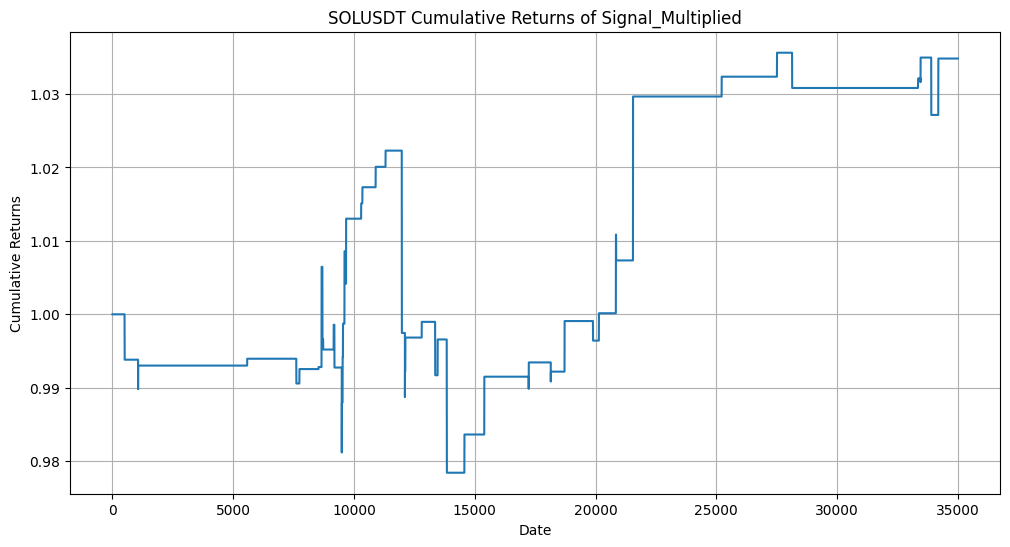

In [4]:
# Add a new column to multiply "Signal" shifted by 1 day by "24HR_Return"
df['Signal_Multiplied'] = df['Signal'].shift(1) * df['percent_change']

# Calculate the sum of the "Signal_Multiplied" column
signal_multiplied_sum = df['Signal_Multiplied'].sum()
print(f"Sum of Signal_Multiplied: {signal_multiplied_sum}")

# Calculate the total return
total_return = (1 + df['Signal_Multiplied']).prod() - 1

# Calculate the number of days in the trading period
#annualized_return = (1 + total_return) ** (365 / trading_days) - 1

print(f"Total Return: {total_return:.2%}")
#print(f"Annualized Return: {annualized_return:.2%}")

# Calculate the maximum drawdown of the "Signal_Multiplied" column
signal_multiplied_cumulative = (1 + df['Signal_Multiplied']).cumprod()
signal_multiplied_max = signal_multiplied_cumulative.cummax()
signal_multiplied_drawdown = (signal_multiplied_cumulative - signal_multiplied_max) / signal_multiplied_max
max_drawdown = signal_multiplied_drawdown.min()
print(f"Maximum Drawdown of Signal_Multiplied: {max_drawdown:.2%}")

# Calculate the number of days the signal was active
signal_active_days = df['Signal'].sum()

# Calculate the percentage of trading days the signal was active
#signal_active_percentage = (signal_active_days / trading_days) * 100

#print(f"Percentage of trading days the signal was active: {signal_active_percentage:.2f}%")

# Create a graph of the cumulative returns of the "Signal_Multiplied" column
plt.figure(figsize=(12, 6))
signal_multiplied_cumulative.plot()
plt.title(f"{symbol} Cumulative Returns of Signal_Multiplied")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.grid()
plt.show() 



In [98]:
# Export the DataFrame to a CSV file
df.to_csv('binance_hour_test.csv', index=False)

print("Data exported to binance_hourly_ohlc_data.csv")

Data exported to binance_hourly_ohlc_data.csv
